# Inference a real model

How to inference a real model trainned by another framework like tensorflow/pytorch/PDPD?

Assume the model is supported by OpenVINO, here is the process of running inference using 
This is little complex in OpenVINO, offline conversion(model optimizer)

## Download onnx model

```bash
wget https://media.githubusercontent.com/media/onnx/models/main/vision/classification/resnet/model/resnet18-v1-7.tar.gz
tar -xf resnet18-v1-7.tar.gz
```

## Read the model

In [1]:
from openvino.preprocess import PrePostProcessor
import openvino.runtime as ov
import numpy as np
import time
from pandas import DataFrame
from graphviz import Digraph, Source
import ovhelper

core = ov.Core()

model = core.read_model("./resnet18-v1-7/resnet18-v1-7.onnx")

# uncomment following line to inspect the model topology
# ovhelper.print_model(model)

Very convenient, now lets compile it into CPU runtime model.

In [2]:
device = 'CPU'
# enable PERF_COUNT
core.set_property(device, {"PERF_COUNT": "YES"})

compiled_model = core.compile_model(model, device)

for k, input in enumerate(compiled_model.inputs):
    print("inputs[{}]: {}".format(k,input))
for k, output in enumerate(compiled_model.outputs):
    print("outputs[{}]: {}".format(k,output))

# uncomment following line if you want to check the runtime model in detail
# rt_model = compiled_model.get_runtime_model()
# ovhelper.visualize_model(rt_model)

inputs[0]: <ConstOutput: names[data] shape{1,3,224,224} type: f32>
outputs[0]: <ConstOutput: names[resnetv15_dense0_fwd] shape{1,1000} type: f32>


We saw a lot of optimization is going around here, including:
 - mapping from ngraph OP to CPU plugin OP
 - fusion of adjacent layers

And all these are done automatically, w/o human intervention, this is the best situation. not we can run inference with it

## Tune performance

Please read following docs for detailed guidline:
https://docs.openvino.ai/2021.3/openvino_docs_optimization_guide_dldt_optimization_guide.html

num_request=1: time_used=3.6 sec, fps=281.5, cpu_usage=48.1%
num_request=8: time_used=3.0 sec, fps=328.0, cpu_usage=50.9%


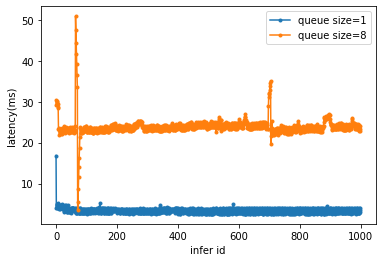

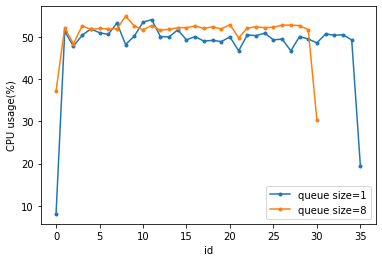

In [3]:
def test_infer_queue(num_request, num_infer, NUM_STREAMS=None, percpu=False, time_limit=None):
    if (NUM_STREAMS):
        core.set_property(device, {"NUM_STREAMS":NUM_STREAMS})
    
    # recompile model each time for property to take effect
    compiled_model = core.compile_model(model, device)

    infer_queue = ov.AsyncInferQueue(compiled_model, num_request)
    cpu_usage = ovhelper.CPUUsage()
    inode = compiled_model.input(0)

    latency_list = []
    prof_list = []
    def callback(request, userdata):
        id = userdata
        latency_list.append(request.latency)
        prof_list.append(request.profiling_info)

    infer_queue.set_callback(callback)

    cpu_usage.start(percpu)
    t0 = time.time()
    for i in range(num_infer):
        wtime = time.time() - t0
        if time_limit and (wtime > time_limit):
            break
        input = ov.Tensor(inode.get_element_type(), inode.get_shape())
        input.data[:] = i
        infer_queue.start_async({0: input}, userdata=i)
    infer_queue.wait_all()
    cpu = cpu_usage.end()
    fps = len(latency_list)/wtime
    return latency_list, prof_list, fps, wtime, cpu

import matplotlib.pyplot as plt

NRlist=[1, 8]
TestResult={}
for num_request in NRlist:
    TestResult[num_request] = test_infer_queue(num_request, 1000)
    latency_list, prof_list, fps, wtime, cpu = TestResult[num_request]
    print("num_request={}: time_used={:.1f} sec, fps={:.1f}, cpu_usage={:.1f}%".format(
                        num_request,
                        wtime,
                        fps, 
                        sum(cpu)/len(cpu)))

def visualize_TestResult(TestResult):
    fig, ax = plt.subplots()
    for num_request, (latency_list, prof_list, fps, wtime, cpu) in TestResult.items():
        ax.plot(latency_list, '.-', label="queue size={}".format(num_request))
    plt.ylabel("latency(ms)")
    plt.xlabel("infer id")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots()
    for num_request, (latency_list, prof_list, fps, wtime, cpu) in TestResult.items():
        ax.plot(cpu, '.-', label="queue size={}".format(num_request))
    plt.ylabel("CPU usage(%)")
    plt.xlabel("id")
    plt.legend()
    plt.show()

visualize_TestResult(TestResult)

The test result is quite supprising:
 - `num_request=8` case has slightly higher performance than `num_request=1` case;
 - `num_request=8` case has slightly higher total cpu usage than `num_request=1` case;
 - `num_request=8` case has about 7~8 times more latency than `num_request=1` case;

the total CPU usage is around ~50% in both cases, this will be further investigated later, for now let's focus on another important setting `NUM_STREAMS` which constrols how many concurrent execution streams (in which a infer request is processed in series op by op) are used for inference.

In [4]:
print("RANGE_FOR_STREAMS: {}".format(core.get_property(device, "RANGE_FOR_STREAMS")))
print("NUM_STREAMS: {}".format(core.get_property(device, "NUM_STREAMS")))

RANGE_FOR_STREAMS: (1, 88)
NUM_STREAMS: 1


Further check the profiling result we still see no differences:

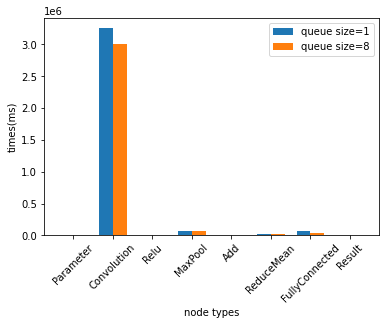

In [5]:
def visualize_profiling(TestResult):
    fig, ax = plt.subplots()
    width = 0.35  # the width of the bars
    dw = width
    for num_request, (latency_list, prof_list, _,_,_) in TestResult.items():
        node_type_times = {}
        for prof in prof_list:
            for p in prof:
                if (p.node_type not in node_type_times):
                    node_type_times[p.node_type] = 0
                node_type_times[p.node_type] += p.real_time.total_seconds()*1e6
        types = []
        times = []
        for k,v in node_type_times.items():
            types.append(k)
            times.append(v)
        x = np.arange(len(types))  # the label locations
        ax.bar(x-dw/2, times, width, label="queue size={}".format(num_request))
        dw = -dw

    ax.set_ylabel("times(ms)")
    ax.set_xlabel("node types")
    ax.set_xticks(x)
    ax.set_xticklabels(types, rotation=45)
    plt.legend()
    plt.show()

visualize_profiling(TestResult)

The fact is, although infer requests are submitted into the execution streams asynchronously, but there is only one execution stream (`NUM_STREAMS` is 1) which is capable of doing only one inference at a time, so latency of 8 infer requests are about 8x of the latency of 1 infer request case beacause each infer request has to wait for other 7 requests to finish before being actually executed by the execution stream.

So when NUM_STREAMS is 1 (which is refered to as `Conventional approach` in [openvino_docs_optimization_guide_dldt_optimization_guide.html](https://docs.openvino.ai/2021.3/openvino_docs_optimization_guide_dldt_optimization_guide.html)), multiple infer requests doesn't bring any performance advantage in terms of inferencing task.

But `num_request=8` case still introduced a little improvement in fps, that's because extra infer request allows the pre-processing part of code in python to be run in parallel with the inferencing of previous infer request, and if there is only 1 infer request, the preprocessing and inferencing can only be run in series.

Now let's try `Throughput-oriented approach` by setting `NUM_STREAMS` to 8 and do the same test again, be aware that you have to re-compile the model for any property changes to take effect:

num_request=1: time_used=22.0 sec, fps=45.4, cpu_usage=8.1%
num_request=8: time_used=1.9 sec, fps=519.8, cpu_usage=40.3%


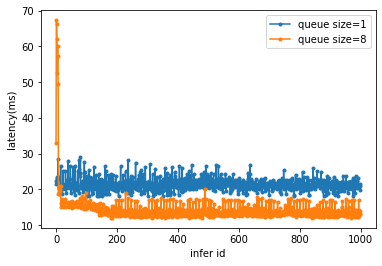

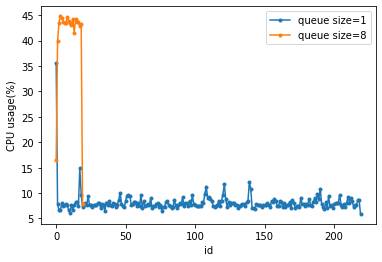

In [6]:
NRlist=[1, 8]
TestResult={}
for num_request in NRlist:
    TestResult[num_request] = test_infer_queue(num_request, 1000, NUM_STREAMS=8)
    latency_list, prof_list, fps, wtime, cpu = TestResult[num_request]
    print("num_request={}: time_used={:.1f} sec, fps={:.1f}, cpu_usage={:.1f}%".format(
                        num_request,
                        wtime,
                        fps, 
                        sum(cpu)/len(cpu)))
visualize_TestResult(TestResult)

And we saw very different result in this case:
 - the `num_request=8, NUM_STREAMS=8` case achieves siginificant higher FPS comparing to `num_request=8, NUM_STREAMS=1` case with even lower cpu usage. As exaplained in `openvino_docs_optimization_guide_dldt_optimization_guide.html`, this is due to:
  > Less threads per stream => less sync, better locality, finer granularity
  
  > "Parallelize the outermost loop" rule of thumb

 - the `num_request=1` case took 7x~8x more times to finish, because now 1 infer request can only be executed on 1/8 resources (all resources are evenly distributed/allocated exclusively to each execution stream).
 - the `num_request=1` case took only about the cpu usage about 1/5 of the `num_request=8` case, in theory it should be 1/8.


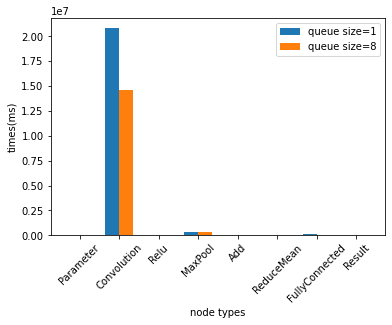

In [7]:
visualize_profiling(TestResult)

## Why only half of the CPU cores are used, even we use 8 as NUM_STREAMS?

NUM_STREAMS=1 num_request=1: time_used=3.3 sec, fps=301.6


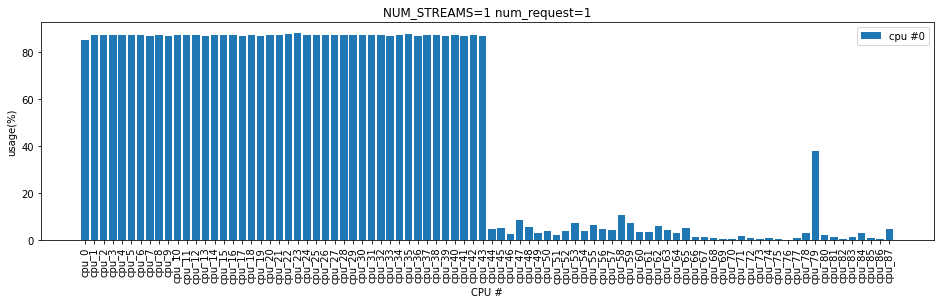

NUM_STREAMS=1 num_request=8: time_used=3.0 sec, fps=338.6


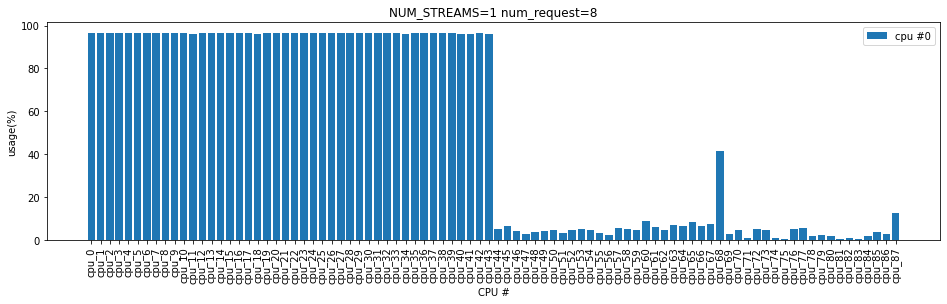

NUM_STREAMS=8 num_request=1: time_used=22.6 sec, fps=44.3


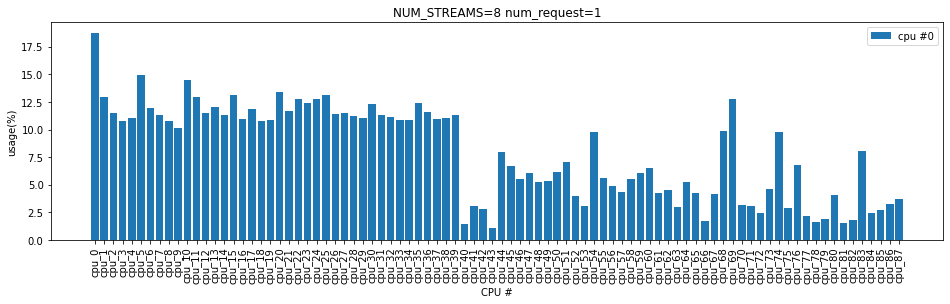

NUM_STREAMS=8 num_request=8: time_used=1.9 sec, fps=524.1


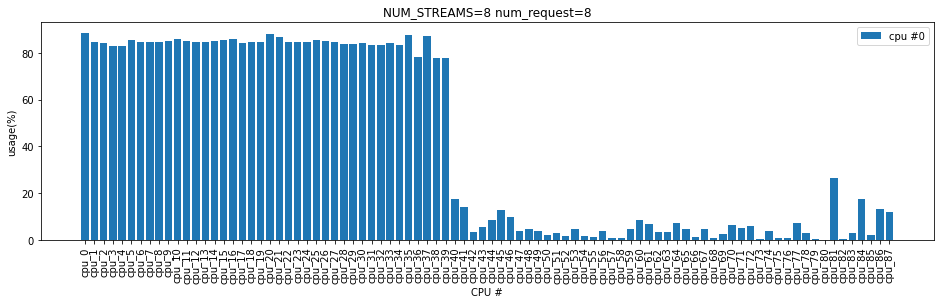

In [8]:
def test_cpu_usage(NUM_STREAMS, num_request):
    latency_list, prof_list, fps, wtime, cpu = test_infer_queue(
                    num_request,
                    1000,
                    NUM_STREAMS=NUM_STREAMS,
                    percpu=True)
    print("NUM_STREAMS={} num_request={}: time_used={:.1f} sec, fps={:.1f}".format(
                        NUM_STREAMS,
                        num_request,
                        wtime,
                        fps))
    cpu_usage = np.array(cpu)

    fig, ax = plt.subplots(figsize=(16,4))
    x = range(cpu_usage.shape[1])
    ax.bar(x, np.mean(cpu_usage, axis=0), label="cpu #{}".format(k))
    ax.set_xlabel("CPU #")
    ax.set_ylabel("usage(%)")
    ax.set_xticks(x)
    ax.set_xticklabels(["cpu_{}".format(num) for num in x], rotation=90)
    ax.set_title("NUM_STREAMS={} num_request={}".format(NUM_STREAMS,num_request))
    plt.legend()
    plt.show()
    #visualize_TestResult(TestResult)

test_cpu_usage(1, 1)
test_cpu_usage(1, 8)
test_cpu_usage(8, 1)
test_cpu_usage(8, 8)

Due to the way linux allocate CPU index to the cores, you may have a misconception that only the first NUMA node is used, even for `NUM_STREAMS=8 num_request=8` case, but actually both NUMA cores are used, even for `NUM_STREAMS=1 num_request=1` case.

Here is what `lscpu` shows:

```bash
CPU(s):              88
On-line CPU(s) list: 0-87
Thread(s) per core:  2
Core(s) per socket:  22
Socket(s):           2
NUMA node(s):        2
...
NUMA node0 CPU(s):   0-21,44-65
NUMA node1 CPU(s):   22-43,66-87
...
```

So we can see actually core 0-43 are from both NUMA nodes, and cores 44-87 are actually Hyperthreads of both NUMA nodes.

That also explains why `NUM_STREAMS=44` is very close to (or even better than) `NUM_STREAMS=88` in terms of performance. 

NUM_STREAMS=44 num_request=44: time_used=1.6 sec, fps=632.9


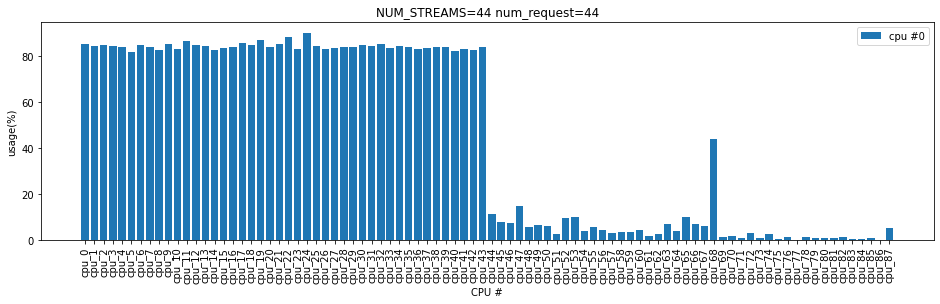

NUM_STREAMS=88 num_request=88: time_used=1.6 sec, fps=618.2


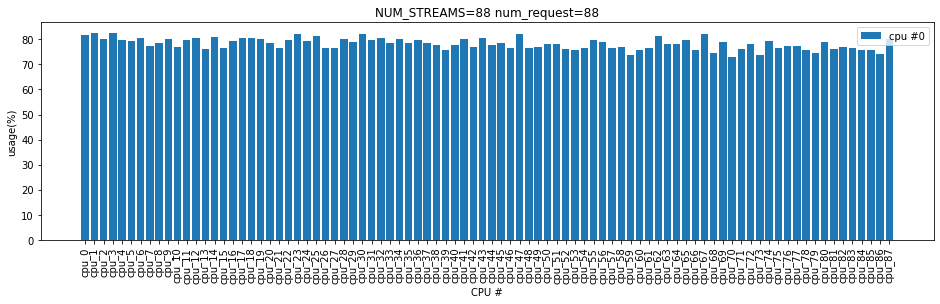

In [9]:
test_cpu_usage(44, 44)
test_cpu_usage(88, 88)

## how to set correct NUM_STREAMS and num_request to achieve higher FPS?

In [10]:
R1 = [str(n) for n in range(0,88,10)] + ["AUTO", "NUMA"]
R1[0] = "1"

R2 = [n for n in range(0,88,10)]
R2[0] = 1

fps_map = np.zeros((len(R1), len(R2)))
cpu_map = np.zeros((len(R1), len(R2)))
for i,NUM_STREAMS in enumerate(R1):
    for j,num_request in enumerate(R2):
        latency_list, prof_list, fps, wtime, cpu = test_infer_queue(
                        num_request,
                        2000,
                        NUM_STREAMS=NUM_STREAMS,
                        percpu=False,
                        time_limit=5)
        print("NUM_STREAMS={} num_request={}: fps={:.1f} cpu={:.1f}%".format(
                        NUM_STREAMS,
                        num_request,
                        fps, np.mean(cpu)))
        fps_map[i, j] = fps
        cpu_map[i, j] = np.mean(cpu)

NUM_STREAMS=1 num_request=1: fps=315.1 cpu=47.8%
NUM_STREAMS=1 num_request=10: fps=339.2 cpu=51.3%
NUM_STREAMS=1 num_request=20: fps=344.6 cpu=50.9%
NUM_STREAMS=1 num_request=30: fps=343.5 cpu=51.0%
NUM_STREAMS=1 num_request=40: fps=345.7 cpu=51.7%
NUM_STREAMS=1 num_request=50: fps=343.2 cpu=51.8%
NUM_STREAMS=1 num_request=60: fps=350.8 cpu=51.1%
NUM_STREAMS=1 num_request=70: fps=354.4 cpu=51.5%
NUM_STREAMS=1 num_request=80: fps=354.4 cpu=51.9%
NUM_STREAMS=10 num_request=1: fps=41.0 cpu=7.1%
NUM_STREAMS=10 num_request=10: fps=560.3 cpu=43.7%
NUM_STREAMS=10 num_request=20: fps=595.5 cpu=46.4%
NUM_STREAMS=10 num_request=30: fps=601.5 cpu=46.4%
NUM_STREAMS=10 num_request=40: fps=603.3 cpu=46.1%
NUM_STREAMS=10 num_request=50: fps=606.5 cpu=46.3%
NUM_STREAMS=10 num_request=60: fps=617.2 cpu=45.7%
NUM_STREAMS=10 num_request=70: fps=620.0 cpu=45.7%
NUM_STREAMS=10 num_request=80: fps=629.2 cpu=47.0%
NUM_STREAMS=20 num_request=1: fps=24.2 cpu=5.6%
NUM_STREAMS=20 num_request=10: fps=240.2 cpu=24

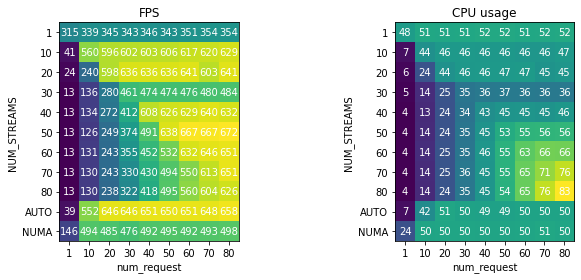

In [11]:
def show_heatmap(ax, map):
    ax.imshow(map)
    # Loop over data dimensions and create text annotations.
    for i in range(map.shape[0]):
        for j in range(map.shape[1]):
            text = ax.text(j, i, "{:.0f}".format(map[i, j]),
                        ha="center", va="center", color="w")
    ax.set_xticks(np.arange(map.shape[1]))
    ax.set_xticklabels([str(r) for r in R2])
    ax.set_yticks(np.arange(map.shape[0]))
    ax.set_yticklabels(R1)
    ax.set_xlabel("num_request")
    ax.set_ylabel("NUM_STREAMS")

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

show_heatmap(ax1, fps_map)
ax1.set_title("FPS")
show_heatmap(ax2, cpu_map)
ax2.set_title("CPU usage")

fig.tight_layout()
plt.show()

We see few things:
 - generally more `NUM_STREAMS` is better, but the improvements becomes slow or saturated after `NUM_STREAMS` reaches 20.
 - `NUM_STREAMS=AUTO` gives reasonable well performance, and from the fact that FPS start saturating from `num_request=10` to 20, we suspect it uses about 10 NUM_STREAMS internally.
 - `NUM_STREAMS=NUMA` uses 2 stream, only one for each NUMA node, we can see CPU usage is high while FPS is low, this means cores in same NUMA nodes still incur too much synchronization overhead.
 - more `NUM_STREAMS` requires more `num_request`, we see FPS becomes saturated only after `num_request > NUM_STREAMS`, this is because we need at least one infer request per stream to exploit all CPU resources, and to further run data preparation and inference in paralell, we need at least one more extra infer-request for data preparation thread to work with.
 - `NUM_STREAMS=1` have lowerest FPS and 50% CPU usage, which means CPU is doing a lot of overhead(synchronizations/memory_stall) in this case.
 - `NUM_STREAMS>40` exploits more than 50% of CPU usage, but as these are hyper-threads of physical cores and we don't have many CPU stalls during NN-inference, so FPS only increases slightly.

actually following code snippet in OpenVINO explained how `NUM_STREAMS` can be set to `NUMA` or `AUTO` rather than a specific number, and according to `GetDefaultNumStreams()`, the default/recommended number of streams in our system with 44 physical cores is 11 when `AUTO` is being specified by user, this aligns with our experiment result.

```cpp
void IStreamsExecutor::Config::SetConfig(const std::string& key, const std::string& value) {
    ...
    } else if (key == ov::num_streams) {
        auto streams = ov::util::from_string(value, ov::streams::num);
        if (streams == ov::streams::NUMA) {
            _streams = static_cast<int32_t>(getAvailableNUMANodes().size());
        } else if (streams == ov::streams::AUTO) {
            // bare minimum of streams (that evenly divides available number of cores)
            _streams = GetDefaultNumStreams();
        } else if (streams.num >= 0) {
            _streams = streams.num;
        } else {
            OPENVINO_UNREACHABLE("Wrong value for property key ",
                                 ov::num_streams.name(),
                                 ". Expected non negative numbers (#streams) or ",
                                 "ov::streams::NUMA|ov::streams::AUTO, Got: ",
                                 streams);
        }
    }
    ...
}
int IStreamsExecutor::Config::GetDefaultNumStreams() {
    const int sockets = static_cast<int>(getAvailableNUMANodes().size());
    // bare minimum of streams (that evenly divides available number of core)
    const int num_cores = sockets == 1 ? std::thread::hardware_concurrency() : getNumberOfCPUCores();
    if (0 == num_cores % 4)
        return std::max(4, num_cores / 4);
    else if (0 == num_cores % 5)
        return std::max(5, num_cores / 5);
    else if (0 == num_cores % 3)
        return std::max(3, num_cores / 3);
    else  // if user disables some cores say in BIOS, so we got weird #cores which is not easy to divide
        return 1;
}
```


We can also see an abnormal dark row in both FPS and CPU heatmap at `NUM_STREAMS=30` with both low FPS and CPU usage. this experiment is repeated few times and confirmed that it's not a coincident.